# Provando ad implementare il codice di un articolo

- [Ispirazione](https://paperswithcode.com/paper/deep-learning-for-ecg-segmentation)
- [Paper](https://arxiv.org/pdf/2001.04689.pdf)
- [Dataset](https://physionet.org/content/ludb/1.0.1)
- [Altro Notebook](https://www.kaggle.com/yschii/find-ecg-wave)


A dir la verità non sono sicuro che il db sia quello giusto. 
Nel paper parlano di 455 ecg a 12 derivazioni, ma in quello che ho scaricato ce ne sono 200

https://www.wintips.org/fix-cpu-not-running-at-full-speed-in-windows-10/#

In [1]:
# first of all install necessary packages
%pip install -U wfdb
%matplotlib inline

Requirement already up-to-date: wfdb in c:\users\scala\lang\lib\site-packages (3.4.1)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\scala\lang\python.exe -m pip install --upgrade pip' command.


In [2]:
# then import necessary packages
import wfdb

import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt

from tensorflow.keras import layers
from keras.models import Model, load_model
from keras.layers import Input, Conv1DTranspose, BatchNormalization, Activation
from keras.layers.core import Dropout, Lambda, Dense
from keras.layers.convolutional import Conv1D, ZeroPadding1D
from keras.layers.pooling import MaxPooling1D
from keras.layers.merge import Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras import backend as K
import tensorflow as tf
# https://stackoverflow.com/questions/66100195/a-tf-variable-created-inside-my-tf-function-has-been-garbage-collected
tf.config.run_functions_eagerly(True)

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical



import tensorflow as tf

### Explore some data

In [3]:
# since the paper handles 12 lead ECG data, i will use 12 leads
LEADS = ['avf', 'avl', 'avr', 'i', 'ii', 'iii', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']
DATA_FOLDER = "./lobachevsky-university-electrocardiography-database-1.0.1/data"
SEGMENT_TO_COLOR = {
    'N': 'blue',
    't': 'green',
    'p': 'red'
}

In [4]:
from typing import Union,List, Tuple

# get signal with wfdb library
# using an index
def get_signal(index:int, as_p_signal:bool=True) -> Union[wfdb.Record, np.ndarray]:
    record = wfdb.rdrecord(DATA_FOLDER + "/" +  str(index))
    assert type(record) is wfdb.Record

    if as_p_signal:
        assert type(record.p_signal) is np.ndarray
        return record.p_signal
        
    return record

# get annotations given the ecg lead
def get_annotations(index:int, lead, as_sample=True) -> Union[wfdb.Annotation, np.ndarray]:
    annotations = wfdb.rdann(DATA_FOLDER +"/" + str(index), extension = lead)
    if as_sample:
        return np.array(annotations.sample)
    return annotations

# get a full EGC with 12 leads
def get_full_ecg(index:int):
    signal = get_signal(index)
    annotations = [
        get_annotations(index, lead) for lead in LEADS
    ]
    return signal, annotations


def get_single_lead_ecg(index, lead) -> Tuple[np.ndarray, np.ndarray]:
    """
    return and ecg signal and its annotations
    both as ndarray
    """
    signal = get_signal(index)
    assert type(signal) is np.ndarray
    signal = signal[:, LEADS.index(lead)]

    samples = get_annotations(index, lead)
    assert type(samples) is np.ndarray
    
    return signal, samples


def get_annotations_symbols(index, lead):
    ann = get_annotations(index, lead, as_sample=False)
    return ann.symbol

def paired_annotation_sample_and_symbol(index, lead):
    annotations_symbols = get_annotations_symbols(index, lead)
    annotations_sample = get_annotations(index, lead)
    return zip(annotations_sample, annotations_symbols)


def get_single_lead_ecg_with_symbols(index, lead):
    """
    return and ecg signal and its annotations
    both as ndarray
    """
    signal = get_signal(index)
    assert type(signal) is np.ndarray
    signal = signal[:, LEADS.index(lead)]

    data = paired_annotation_sample_and_symbol(index, lead)
    
    return signal, np.array(list(data))

# plot single lead ecg with annotations
def plot_single_lead_ecg(index, lead):
    signal, samples = get_single_lead_ecg(index, lead)

    fig, ax = plt.subplots(figsize = (28, 3))

    ax.plot(signal)
    ax.scatter(samples, signal[samples], c = 'r', marker = 'o')


# now plot every lead with annotations
def plot_signal_with_annotation(index):
    signal, samples = get_full_ecg(index)
    # extract sample from annotations
    wfdb.plot_items(signal, samples )


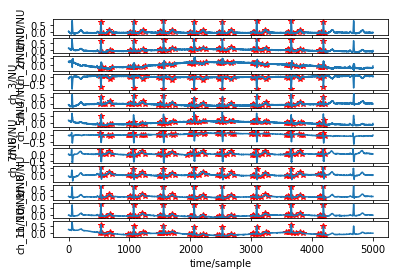

In [5]:
plot_signal_with_annotation(199)   

### Plotto anche una sola derivazione
La descrizione dell'articolo dice che gli ECG sono lunghi 10sec. Se in 10sec sono stati presi 5000 campioni, allora l'ECG andava a 500Hz.

In [6]:
def grouped(itr, n=3):
    itr = iter(itr)
    end = object()
    while True:
        vals = tuple(next(itr, end) for _ in range(n))
        if vals[-1] is end:
            return
        yield vals

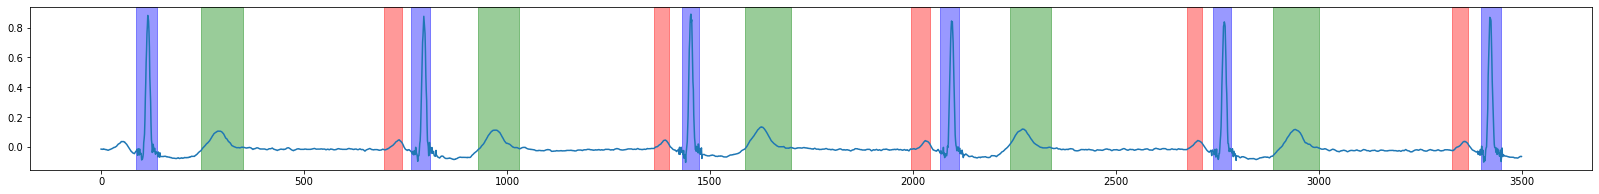

In [7]:
class EGCSignal:
    def __init__(self, signal, time_points, symbol):
        """
        signal: ndarray

        """
        self.signal:np.ndarray = signal
        self.time_points:np.ndarray = time_points
        self.symbols:list[str] = symbol
        self.symbol_to_category = {
            'N': 0,
            't': 1,
            'p': 2
        }
        self.category_to_symbol = {
            0: 'N',
            1: 't',
            2: 'p'
        }
        self.categories = self.symbols_to_category()
        self._cut_beginning( 550)
        self._cut_end( 3500)

    def __getitem__(self, key):
        return self.signal[key]

    def __len__(self):
        return len(self.signal)

    def _cut_beginning(self, start_point):
        self.signal = self.signal[start_point:]
        self.categories = self.categories[start_point:]

        # now have to check if time_points and symbols are also to cut
        if start_point > self.time_points[0]:
            # get the index of the first time point greater than start_point
            index = np.argmax(self.time_points > start_point)                
            self.time_points = self.time_points[index:]
            self.symbols = self.symbols[index:]

        self.time_points = self.time_points - start_point

        # check the cut point
        if self.categories[0] != -1:
            # if the first symbol is a ')' then i have to prepend a '(' and a letter from self.category_to_symbol
            if self.symbols[0] == ')':
                self.symbols = ['('] + [self.category_to_symbol[self.categories[0]]] + self.symbols
                self.time_points = np.concatenate(([0,1], self.time_points))
            elif self.symbols[0] in self.symbol_to_category:
                # just prepend '('
                self.symbols = ['('] + self.symbols
                self.time_points = np.concatenate(([0], self.time_points))

    def _cut_end(self, end_point):
        self.signal = self.signal[:end_point]
        self.categories = self.categories[:end_point]

        index = self.time_points[self.time_points < self.signal.size].size
        self.time_points = self.time_points[:index]
        self.symbols = self.symbols[:index]

        # check the cut point
        if self.categories[-1] != -1:
            # if the last symbol is a '(' then i have to append a ')' and a letter from self.category_to_symbol
            if self.symbols[-1] == '(':
                self.symbols = self.symbols +  [self.category_to_symbol[self.categories[-1]]] + [')']
                self.time_points = np.concatenate((self.time_points, [self.signal.size - 1, self.signal.size ]))
            elif self.symbols[-1] in self.symbol_to_category:
                # just append ')'
                self.symbols = self.symbols + [')']
                self.time_points = np.concatenate((self.time_points, [self.signal.size]))
 
    def plot(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize = (28, 3))
        ax.plot(self.signal)

    def plot_with_time_point(self):
        fig, ax = plt.subplots(figsize = (28, 3))
        self.plot(ax)
        ax.scatter(self.time_points, self.signal[self.time_points], c = 'r', marker = 'o')

    def plot_with_segments(self):
        fig, ax = plt.subplots(figsize = (28, 3))
        self.plot(ax)

        for start, symbol, end in grouped(self.time_points, 3):            
            i = np.nonzero(self.time_points == symbol)[0][0]
            current_symbol = self.symbols[i]
            color = SEGMENT_TO_COLOR[current_symbol]
            ax.axvspan(start, end, color=color, alpha=0.4)

    def symbols_to_category(self):
        """
        converts the symbols list in a numpy array of integers
        same length as the signal
        """

        # first instantiate an array of -1 same length as the signal
        category = np.full(len(self.signal), -1)
        # now fill the array with the known category
        for section in grouped(self.time_points):
            # unpack the section
            start, peak, end = section
            
            
            # get the category given the peak
            i = np.nonzero(self.time_points == peak)[0][0]
            current_symbol = self.symbols[i]

            category[start:end] = self.symbol_to_category[current_symbol]

        return category

    @staticmethod
    def from_index_and_lead(index, lead):
        return EGCSignal(
        get_signal(index)[:, LEADS.index(lead)],
        get_annotations(index, lead),
        get_annotations_symbols(index, lead) )



EGCSignal.from_index_and_lead(1, LEADS[0]).plot_with_segments()


Per qualche ragione, non tutti gli ecg escono col buco e certi mi risultano annotati male quindi non li considerero nel dataset
Farò una lista per escluderli.

In [8]:
# create a list of not working ecgs
not_working_ecgs = []
for i in range(1,200):
    for lead in LEADS:
        try: EGCSignal.from_index_and_lead(i, lead)
        except: not_working_ecgs.append((i, lead))

### Incomincio a preparare X e Y per la rete
siccome mi sono un po scomodi i dati, mi faccio un classe per rappresenatare tutto

In [9]:
import random


X = []
Y = []
for ecg_index in range(1,200):
    for lead in LEADS:
        if (ecg_index, lead) not in not_working_ecgs:
            for ecg_part in range(0, 4):
                s = EGCSignal.from_index_and_lead(ecg_index, lead)

                span = 510
                start = random.randint(0, 30) + ecg_part*span
                s._cut_beginning(start)
                s._cut_end(span)

                # append the signal to X, also adding a new dimension
                X.append(s.signal)
                # append the category to Y
                Y.append(to_categorical(s.categories + 1, num_classes = 4).astype(np.float32))


KeyboardInterrupt: 

In [ ]:

"""
now i ll make a kind of UNet
as described in the paper

(i) 4 blocks, each of which includes two convolutional layers with batch normal-
ization and the Relu activation function; these blocks are connected sequen-
tially with MaxPooling layers

(ii) he output from the previous layer through the MaxPooling layer is fed to
the input of another block containing two convolutional layers with batch
normalization and the Relu activation function

(iii) he output from the previous layer through the deconvolution and zero
padding layers is concatenated with the output from the layer (ii) and is
fed to the input of the block that includes two convolutional layers each
with the batch normalization and the Relu activation function

(iv) he output from the previous layer through the deconvolution and zero
padding layers is sequentially fed to the input of another 4 blocks containing
two convolutional layers each with batch normalization and Relu activation
function; each time the output is concatenated with the output from the
corresponding layers (i) in the reverse order

(v) he output from the previous layer is fed to the input of another convolutional
layer


"""

'\nnow i ll make a kind of UNet\nas described in the paper\n\n(i) 4 blocks, each of which includes two convolutional layers with batch normal-\nization and the Relu activation function; these blocks are connected sequen-\ntially with MaxPooling layers\n\n(ii) he output from the previous layer through the MaxPooling layer is fed to\nthe input of another block containing two convolutional layers with batch\nnormalization and the Relu activation function\n\n(iii) he output from the previous layer through the deconvolution and zero\npadding layers is concatenated with the output from the layer (ii) and is\nfed to the input of the block that includes two convolutional layers each\nwith the batch normalization and the Relu activation function\n\n(iv) he output from the previous layer through the deconvolution and zero\npadding layers is sequentially fed to the input of another 4 blocks containing\ntwo convolutional layers each with batch normalization and Relu activation\nfunction; each time

In [ ]:


class ConvPassLayer(layers.Layer):
    def __init__(self, n_conv_filters, activation='relu', **kwargs):
        super(ConvPassLayer, self).__init__(**kwargs)
        self.n_conv_filters = n_conv_filters
        self.activation = activation

    def build(self, input_shape):
        self.input_layer = input_shape

    def call(self, x):
        # apply 4 padding in 1 dimension
        pad1 = ZeroPadding1D(padding=4)(x)
        # apply a convolution with kernel size 9
        conv1 = Conv1D(filters = self.n_conv_filters, kernel_size = 9)(pad1)
        # apply batch normalization
        bn1 = BatchNormalization()(conv1)
        # apply activation function
        act1 = Activation(self.activation)(bn1)
        return act1

    def compute_output_shape(self, input_shape):
        return input_shape

def UNET(inpusize = 510):
    inputs = Input((inpusize, 1))
    block1layer1 = ConvPassLayer(4)(inputs)
    block1layer2 = ConvPassLayer(4)(block1layer1)

    pool1 = MaxPooling1D(2)(block1layer2)
    block2layer1 = ConvPassLayer(8)(pool1)
    block2layer2 = ConvPassLayer(8)(block2layer1)

    transposed = Conv1DTranspose(filters = 8, kernel_size = 2, strides = 2, padding = 'same', activation = 'relu')(block2layer2)
    block1layer3 = Concatenate()([transposed, block1layer2])
    block1layer4 = ConvPassLayer(4)(block1layer3)
    block1layer5 = ConvPassLayer(4, activation='sigmoid')(block1layer4)

    return Model(inputs, block1layer5)


m = UNET()
m.summary()
print(f"""
{m.predict(X[0].reshape(1, 510, 1))[0]}

{m.predict(X[0].reshape(1, 510, 1))[0].shape}
""")


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 510, 1)]     0           []                               
                                                                                                  
 conv_pass_layer (ConvPassLayer  (None, 510, 4)      0           ['input_1[0][0]']                
 )                                                                                                
                                                                                                  
 conv_pass_layer_1 (ConvPassLay  (None, 510, 4)      0           ['conv_pass_layer[0][0]']        
 er)                                                                                              
                                                                                              

C:\Users\scala\lang\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4526: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(



[[0.49986374 0.49995482 0.49999434 0.49989405]
 [0.4999208  0.49997896 0.500025   0.49984947]
 [0.49988222 0.5000747  0.4999663  0.4998079 ]
 ...
 [0.49995106 0.50002563 0.50005186 0.49981627]
 [0.49979696 0.50027657 0.49993554 0.49975115]
 [0.4998905  0.50015503 0.49984905 0.49984354]]

(510, 4)



In [ ]:
len(X)/3*2 / 16

393.0

In [ ]:
# model = make_kind_of_u_net()

m.compile(optimizer='sgd', loss='binary_crossentropy') 


# split the data in train and test
X_train, X_test, Y_train, Y_test = train_test_split(
    np.array(X),#X,
    np.array(Y, dtype=np.float32),#Y,
    test_size=0.25)

m.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=16,
    #validation_data=(X_test, Y_test)
)


Epoch 1/50
176/443 [==========>...................] - ETA: 40s - loss: 0.7754

KeyboardInterrupt: 

In [ ]:
model.predict(
    X_test[3][np.newaxis, : ]
)[0]

array([[0.44471407, 0.48993805, 0.3122332 , 0.35343343],
       [0.46861917, 0.4331997 , 0.5047819 , 0.33158505],
       [0.36956835, 0.4746069 , 0.52353036, 0.37419027],
       ...,
       [0.54803896, 0.53818697, 0.32211483, 0.21957362],
       [0.44953865, 0.5897091 , 0.39185563, 0.3439476 ],
       [0.5378357 , 0.5995744 , 0.42580515, 0.3966997 ]], dtype=float32)

In [ ]:
Y_test[3]

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [ ]:
_xm = np.argmax(model.predict(
    X_test[3][np.newaxis, : ]
)[0], axis=1)
_ym = np.argmax(Y_test[3], axis=1)

_xm - _ym == 0

array([False,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [ ]:
_xm

array([1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,